# Multivariate, Multi-step, Multivariate (Output) Time Series Forecasting using Stacked LSTM Seq2Seq Autoencoder architecture using Tensorflow 2: _Bitcoin recurrence modelling_

The Bitcoin data has been obtained from [Yahoo Finance](https://finance.yahoo.com).

In [2]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.io import loadmat
import scipy
from scipy.fftpack import fft
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly
# import plotly.express as px
import pickle

In [4]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [5]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-08-19 12:35:37.669802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:35:37.721939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:35:37.722109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:35:37.723181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
# Read Lenze CSV data-
data = pd.read_csv("Datasets/BTC-USD.csv", low_memory = True)

In [7]:
data.shape

(1827, 7)

In [8]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
# Convert to datetime format, sort in ascending order and
# reset indices-
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [10]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,4073.260010,3159089920


In [11]:
data['Date'].min(), data['Date'].max()

(Timestamp('2017-08-09 00:00:00'), Timestamp('2022-08-09 00:00:00'))

In [12]:
for col in data.columns.tolist():
    if col == 'Date':
        continue
    else:
        print(f"{col}; min = {data[col].min():.4f} & max = {data[col].max():.4f}")

Open; min = 3166.3000 & max = 67549.7344
High; min = 3275.3779 & max = 68789.6250
Low; min = 2946.6201 & max = 66382.0625
Close; min = 3154.9500 & max = 67566.8281
Adj Close; min = 3154.9500 & max = 67566.8281
Volume; min = 768014976.0000 & max = 350967941479.0000


In [13]:
# Remove 'Adj Close' feature-
data.drop(labels = ['Adj Close'], axis = 1, inplace = True)

In [14]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,3159089920


In [15]:
# Visualize distribution using histograms-
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 43


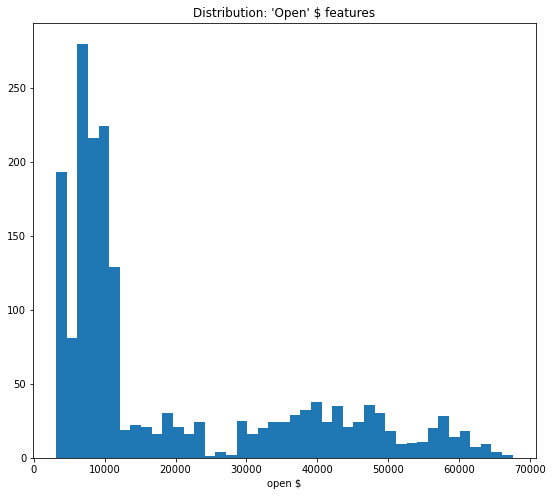

In [16]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Open'], bins = num_bins)
plt.xlabel("open $")
plt.title("Distribution: 'Open' $ features")
plt.show()

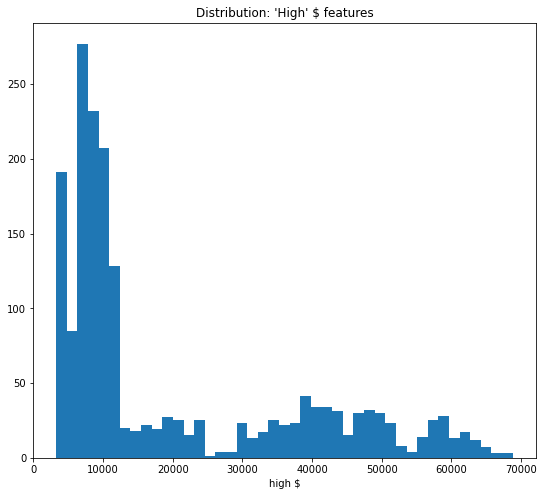

In [17]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['High'], bins = num_bins)
plt.xlabel("high $")
plt.title("Distribution: 'High' $ features")
plt.show()

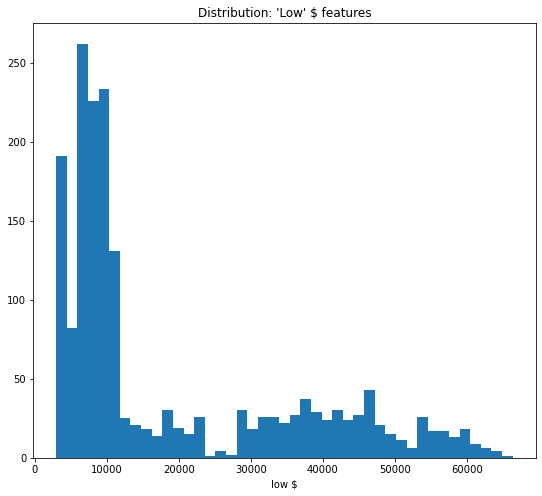

In [18]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Low'], bins = num_bins)
plt.xlabel("low $")
plt.title("Distribution: 'Low' $ features")
plt.show()

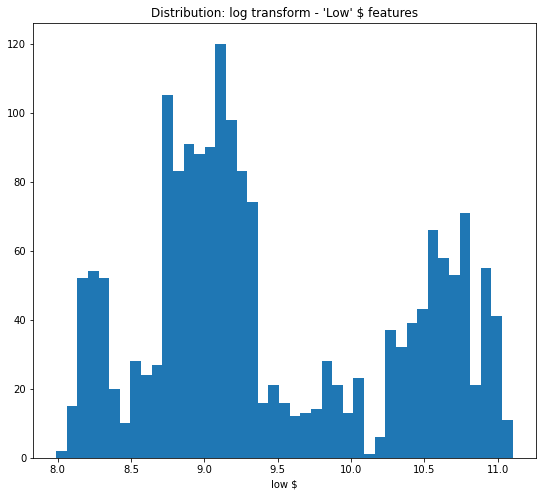

In [19]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Low']), bins = num_bins)
plt.xlabel("low $")
plt.title("Distribution: log transform - 'Low' $ features")
plt.show()

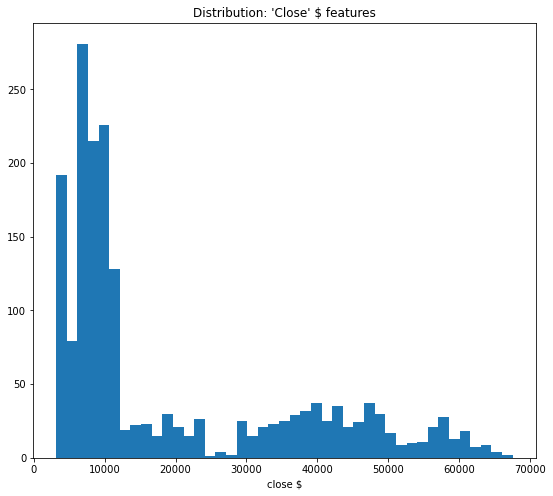

In [20]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Close'], bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: 'Close' $ features")
plt.show()

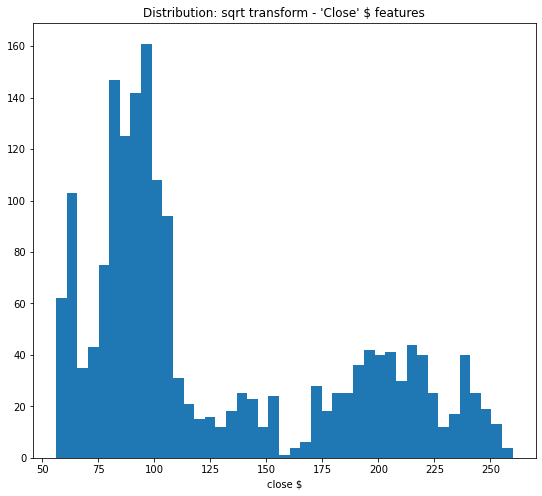

In [21]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.sqrt(data['Close']), bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: sqrt transform - 'Close' $ features")
plt.show()

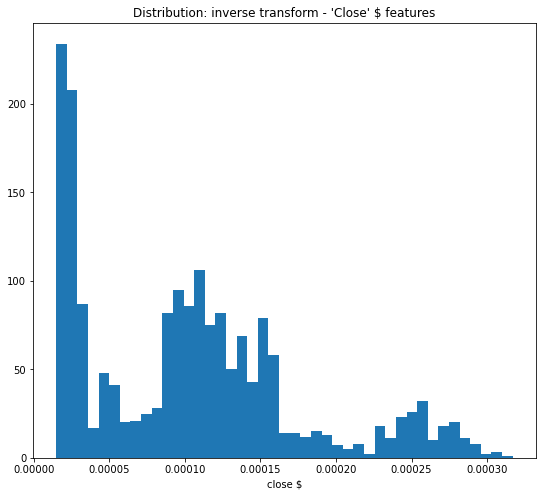

In [22]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(1 / data['Close'], bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: inverse transform - 'Close' $ features")
plt.show()

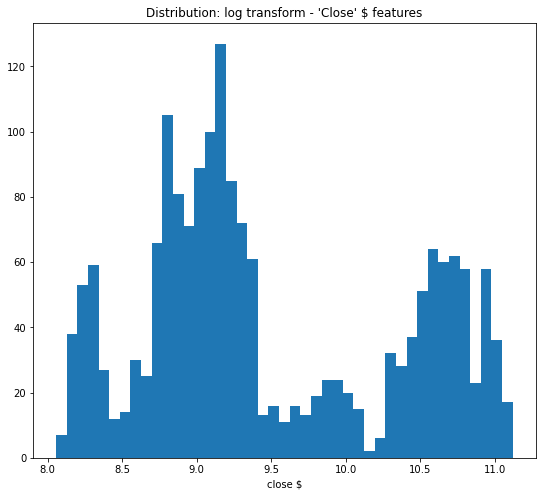

In [23]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Close']), bins = num_bins)
plt.xlabel("close $")
plt.title("Distribution: log transform - 'Close' $ features")
plt.show()

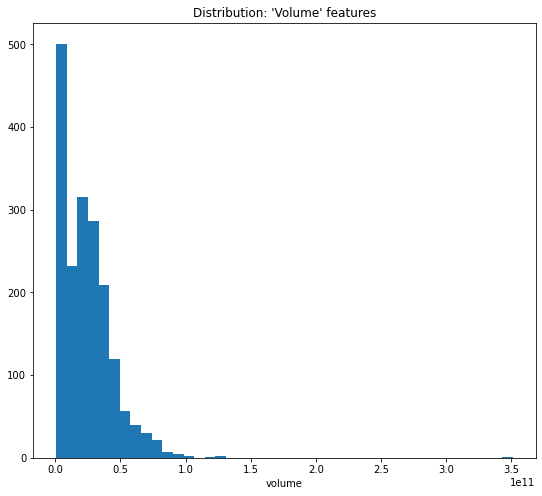

In [24]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(data['Volume'], bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution: 'Volume' features")
plt.show()

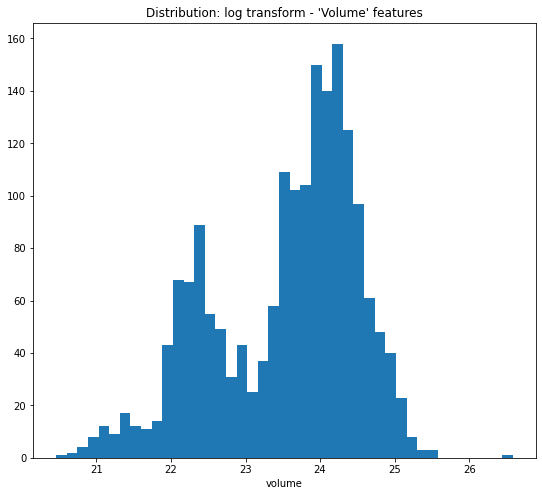

In [25]:
plt.figure(figsize = (9, 8))
n, b, _ = plt.hist(np.log(data['Volume']), bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution: log transform - 'Volume' features")
plt.show()

#### Data processing has been done with ```log``` transform as it seems to work the best for this (almost) right skewed distribution.

In [26]:
# Apply log transform to all numeric features-
data_log = np.log(data.iloc[:, 1:])

In [27]:
data_log.shape

(1827, 5)

In [28]:
# Convert to float32-
data_log = data_log.astype(np.float32)

In [29]:
# Specify hyper-parameters for neural network training-
num_epochs = 100
batch_size = 256

### Split ```data``` to avoid _data leakage_

#### Train: Test split: _90:10_ 

In [30]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data_log[: int(len(data_log) * 0.9)]), len(data_log[int(len(data_log) * 0.9): ])

(1644, 183)

In [31]:
# Sanity check-
len(data_log[: int(len(data_log) * 0.9)]) + len(data_log[int(len(data_log) * 0.9): ]) == len(data_log)

True

In [32]:
# Create train and test sets-
train_data = data_log[: int(len(data_log) * 0.9)]
test_data = data_log[int(len(data_log) * 0.9): ]

In [33]:
# Sanity check-
train_data.shape, test_data.shape

((1644, 5), (183, 5))

In [34]:
# Further sanity check-
train_data.iloc[-5:, :]

,Open,High,Low,Close,Volume
1639,10.517180,10.522843,10.501652,10.522843,23.645971
1640,10.522699,10.634118,10.521200,10.633470,24.104675
1641,10.633485,10.641779,10.622256,10.632030,23.701488
1642,10.632029,10.657278,10.627283,10.655197,23.504696
1643,10.655064,10.701036,10.639411,10.688309,24.078135


In [35]:
test_data.iloc[:5, :]

,Open,High,Low,Close,Volume
1644,10.688636,10.720927,10.664476,10.694633,24.222176
1645,10.694140,10.708350,10.674358,10.699615,23.869394
1646,10.699819,10.729004,10.678280,10.682012,24.193432
1647,10.682150,10.687636,10.648149,10.655091,24.017431
1648,10.655193,10.668782,10.641909,10.651229,23.622068


In [36]:
data_log.iloc[1641:1647, :]

,Open,High,Low,Close,Volume
1641,10.633485,10.641779,10.622256,10.632030,23.701488
1642,10.632029,10.657278,10.627283,10.655197,23.504696
1643,10.655064,10.701036,10.639411,10.688309,24.078135
1644,10.688636,10.720927,10.664476,10.694633,24.222176
1645,10.694140,10.708350,10.674358,10.699615,23.869394
1646,10.699819,10.729004,10.678280,10.682012,24.193432


In [37]:
# Scale with Min-max scaler-

# Initialize and train only on train dataset-
mm_scaler = MinMaxScaler(feature_range = (-1, 1))
train_data = mm_scaler.fit_transform(train_data.values)

# Transform test dataset with trained scaled from above-
test_data = mm_scaler.transform(test_data.values)

# VAE should consequently use 'tanh' activation function in last layer!

In [38]:
# Sanity check-
train_data.shape, test_data.shape

((1644, 5), (183, 5))

In [39]:
# Sanity check-
print(f"min-max values for train dataset are: ")
for col in range(train_data.shape[1]):
    print(f"{col}; min = {train_data[:, col].min():.4f} &"
          f" max = {train_data[:, col].max():.4f}")

min-max values for train dataset are: 
0; min = -1.0000 & max = 1.0000
1; min = -1.0000 & max = 1.0000
2; min = -1.0000 & max = 1.0000
3; min = -1.0000 & max = 1.0000
4; min = -1.0000 & max = 1.0000


In [40]:
# Sanity check-
print(f"min-max values for test dataset are: ")
for col in range(test_data.shape[1]):
    print(f"{col}; min = {test_data[:, col].min():.4f} &"
          f" max = {test_data[:, col].max():.4f}")

min-max values for test dataset are: 
0; min = 0.1714 & max = 0.7693
1; min = 0.1676 & max = 0.7648
2; min = 0.1515 & max = 0.7797
3; min = 0.1725 & max = 0.7695
4; min = -0.0582 & max = 0.4753


In [41]:
def split_series_multivariate(data, n_past, n_future):
    '''
    Create training and testing splits required by Seq2Seq
    architecture(s) for multivariate, multistep and multivariate
    output time-series modeling.
    '''
    X, y = list(), list()
    
    for window_start in range(len(data)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(data):
            break
            
        # slice past and future parts of window-
        past, future = data[window_start: past_end, :], data[past_end: future_end, :]
        # past, future = data[window_start: past_end, :], data[past_end: future_end, 4]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)


In [42]:
# Define hyper-parameters for Seq2Seq modeling:

# look-back window size-
n_past = 50

# number of future steps to predict for-
n_future = 10

# number of features used-
n_features = data_log.shape[1]

In [43]:
print(f"Training LSTM encoder-decoder architecture with: look back = {n_past},"
      f" look ahead = {n_future} using {n_features} attributes")

Training LSTM encoder-decoder architecture with: look back = 50, look ahead = 10 using 5 attributes


In [44]:
# Split into training and testing sets for supervised task-
X_train, y_train = split_series_multivariate(train_data, n_past, n_future)
X_test, y_test = split_series_multivariate(test_data, n_past, n_future)

In [45]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1585, 50, 5), y_train.shape: (1585, 10, 5)
X_test.shape: (124, 50, 5), y_test.shape: (124, 10, 5)


In [46]:
# Convert to float-32 values-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [47]:
print(f"One training epoch has {int(X_train.shape[0] / batch_size)} steps and"
      f" one validation epoch has {int(X_test.shape[0] / batch_size)} steps"
     )

One training epoch has 6 steps and one validation epoch has 0 steps


In [ ]:
# Create TF train and test dataset to iterate over-
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = batch_size, drop_remainder = True)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size = batch_size, drop_remainder = True)

In [ ]:
# Sanity check-
# x, y = next(iter(train_dataset))
# x.shape, y.shape

In [ ]:
# x_t, y_t = next(iter(test_dataset))
# x_t.shape, y_t.shape

In [ ]:
# del x, y, x_t, y_t

In [48]:
del train_data, test_data, data

### Define _Seq2Seq_ architecture for _Multivariate, Multistep & Multivariate_ output architecture


In Seq2Seq Learning, an RNN model is trained to map an input sequence to an output sequence. The input and output need not necessarily be of the same length. The seq2seq model contains two RNNs, e.g., LSTMs. They can be treated as an encoder and decoder. _The encoder converts the given input sequence to a fixed-length vector, which acts as a summary of the input sequence_.

__This fixed-length vector is called the context vector. The _context vector_ is given as input to the decoder and the final encoder state as an initial decoder state to predict the output sequence__. Sequence to Sequence learning is used in language translation, speech recognition, time series
forecasting, etc.

We will use the Seq2Seq learning for time series forecasting. We can use this architecture to compute multistep forecasts. We will add two layers, a ```RepeatVector``` layer and ```TimeDistributed(Dense))``` layer in the architecture.

- __A repeat vector layer is used to repeat the context vector we get from the encoder to pass it as an input to the decoder__.
- __We will repeat it for n-steps (_n_ is the number of future steps you want to forecast for)__.
- __The output received from the decoder with respect to each time step is mixed. The time distributed densely will apply a fully connected dense layer on each time step and separates the output for each timestep__. The time distributed layer is a wrapper that allows applying a layer to every temporal slice of an input.

We will stack additional layers on the encoder and the decoder parts of the Seq2Seq architecture. By stacking LSTM’s, it may increase the ability of our model to understand more complex representation of our time-series data in hidden layers, by capturing information at different levels.

[Reference](https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/)

#### Sequence to Sequence Model with _3_ encoder layers and _3_ decoder layers

In [49]:
# Define LSTM encoder-
encoder_input = Input(shape = (n_past, n_features))
encoder_layer1 = LSTM(
    units = 256, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)(encoder_input)
encoder_layer2 = LSTM(
    units = 256, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)(encoder_layer1[0], initial_state = encoder_layer1[1:])
encoder_layer3 = LSTM(
    units = 256, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)(encoder_layer2[0], initial_state = encoder_layer2[1:])
# encoder_output3 = encoder_layer3(encoder_output2[0], initial_state = encoder_output2[1:])

2022-08-19 12:37:29.940147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 12:37:29.942057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:37:29.942285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:37:29.942436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [50]:
# Define LSTM decoder-

# 'RepeatVector' accepts as input 'hn' for last input time step from 'encoder_layer3'-
decoder_input = RepeatVector(n = n_future)(encoder_layer3[1])
decoder_layer1 = LSTM(
    units = 256, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)(decoder_input, initial_state = encoder_layer3[1:])
decoder_layer2 = LSTM(
    units = 256, return_sequences = True,
    return_state = True, activation = tf.keras.activations.tanh
)(decoder_layer1[0], initial_state = decoder_layer1[1:])
decoder_layer3 = LSTM(
    units = 256, return_sequences = True,
    activation = tf.keras.activations.tanh
)(decoder_layer2[0], initial_state = decoder_layer2[1:])
decoder_outputs = TimeDistributed(Dense(units = n_features))(decoder_layer3)

In [51]:
# Initialize LSTM encoder-decoder architecture-
model = Model(inputs = encoder_input, outputs = decoder_outputs)

In [52]:
# Sanity check-
x = X_train[:batch_size, :, :]
y = y_train[:batch_size, :, :]

In [53]:
# x_enc = model_encoder(x)
pred = model(x)

2022-08-19 12:37:35.540367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-08-19 12:37:35.640883: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [54]:
pred.shape, y.shape, x.shape

(TensorShape([256, 10, 5]), (256, 10, 5), (256, 50, 5))

In [55]:
del x, y, pred

### Define _Bi-directional_ LSTM architecture

In [ ]:
"""
# Encoder-
encoder_inputs_bi = Input(shape = (n_past, n_features))
encoder_l1_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        return_state = True, activation = tf.keras.activations.tanh
    )
)
encoder_outputs1_bi = encoder_l1_bi(encoder_inputs_bi)
encoder_states1_bi = encoder_outputs1_bi[1:]
encoder_l2_bi = Bidirectional(
    LSTM(
        100, return_state = True,
        activation = tf.keras.activations.tanh
    )
)
encoder_outputs2_bi = encoder_l2_bi(encoder_outputs1[0])
encoder_states2_bi = encoder_outputs2_bi[1:]
"""

In [ ]:
"""
# Decoder-
decoder_inputs_bi = RepeatVector(n_future)(encoder_outputs2_bi[0])

decoder_l1_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        activation = tf.keras.activations.tanh
    )
)(decoder_inputs_bi, initial_state = encoder_states1_bi)
decoder_l2_bi = Bidirectional(
    LSTM(
        units = 100, return_sequences = True,
        activation = tf.keras.activations.tanh
    )
)(decoder_l1_bi, initial_state = encoder_states2_bi)
decoder_outputs2_bi = TimeDistributed(
    Dense(units = n_features))(decoder_l2_bi)
"""

In [ ]:
# Define Bi-directional model-
# model_e2d2_bi = Model(inputs = encoder_inputs_bi, outputs = decoder_outputs2_bi) 

In [56]:
# Get model summary-
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    268288      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 50, 256),    525312      ['lstm[0][0]',                   
                                 (None, 256),                     'lstm[0][1]',               

In [ ]:
# Define LR scheduler-
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [57]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.00001,
    patience = 20, verbose = 1,
    mode = 'auto', baseline = None,
    restore_best_weights = True
)

In [58]:
# Compile model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
    # loss = tf.keras.losses.MeanSquaredError()
)

In [59]:
print(f"Train LSTM encoder-decoder architecture for {num_epochs} epochs")

Train LSTM encoder-decoder architecture for 100 epochs


In [60]:
# Train model-
train_history = model.fit(
    x = X_train, y = y_train,
    epochs = num_epochs, batch_size = batch_size,
    validation_data = (X_test, y_test),
    verbose = 1,
    # callbacks = [reduce_lr, early_stopping_criterion]
    callbacks = [early_stopping_criterion]
)

Epoch 1/100
7/7 [==============================] - 5s 163ms/step - loss: 0.1056 - val_loss: 0.0539
Epoch 2/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0619 - val_loss: 0.1022
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0239 - val_loss: 0.0187
Epoch 4/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0129 - val_loss: 0.0195
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0080 - val_loss: 0.0133
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 9/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 10/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 11/100
7/7 [

In [61]:
# Save trained weights-
model.save_weights("Bitcoin-LSTM_E3D3_Trained.h5", overwrite = True)

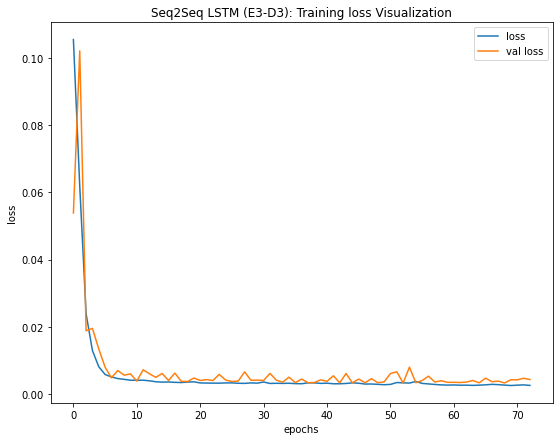

In [62]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Seq2Seq LSTM (E3-D3): Training loss Visualization")
plt.show()

In [85]:
# Initialize and Load 'best' trained weights-
trained_model = Model(inputs = encoder_input, outputs = decoder_outputs)
trained_model.load_weights("Bitcoin-LSTM_E3D3_Trained.h5")

In [86]:
# Compile model-
trained_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.Huber()
    # loss = tf.keras.losses.MeanSquaredError()
)

In [87]:
# Compute predictions-
predictions = trained_model.predict(X_test)

In [88]:
# Sanity check-
y_test.shape, predictions.shape

((124, 10, 5), (124, 10, 5))

In [89]:
# Define two lists to contain true vs. predicted values-
true_vals = []
pred_vals = []

In [90]:
for i in range(y_test.shape[0]):
    true_vals.append(y_test[i, 0, :])

In [91]:
for i in range(len(predictions)):
    pred_vals.append(predictions[i, 0, :])

In [92]:
# Convert to numpy arrays-
true_vals = np.asarray(true_vals)
pred_vals = np.asarray(pred_vals)

In [93]:
# Sanity check-
true_vals.shape, pred_vals.shape

((124, 5), (124, 5))

### Remember to _inverse scale_ followed by ```exp()``` to get the final values in the correct scale.

In [94]:
# Reverse scaling-
pred_vals = mm_scaler.inverse_transform(pred_vals)
true_vals = mm_scaler.inverse_transform(true_vals)

In [95]:
# Inverse of log() with exp()-
pred_vals = np.exp(pred_vals)
true_vals = np.exp(true_vals)

In [96]:
# Sanity check-
pred_vals.shape, true_vals.shape

((124, 5), (124, 5))

### Visualize true vs. predicted values ∀ attributes

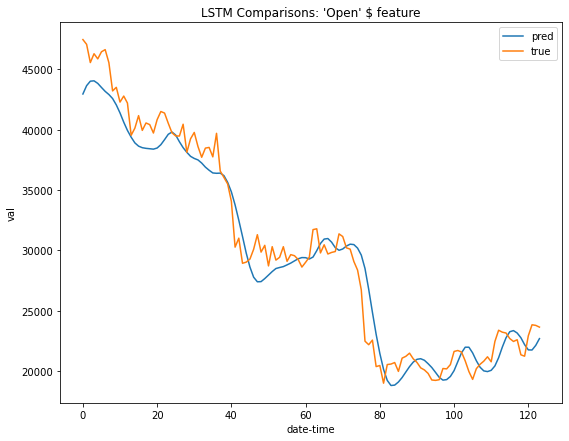

In [97]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 0].flatten(), label = 'pred')
plt.plot(true_vals[:, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Open' $ feature")
plt.legend(loc = 'best')
plt.show()

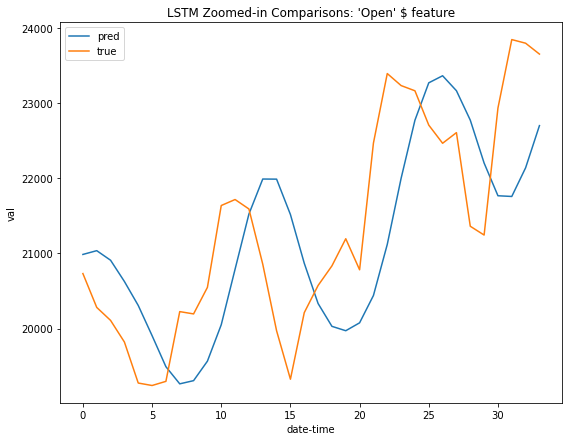

In [98]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 0].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 0].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Open' $ feature")
plt.legend(loc = 'best')
plt.show()

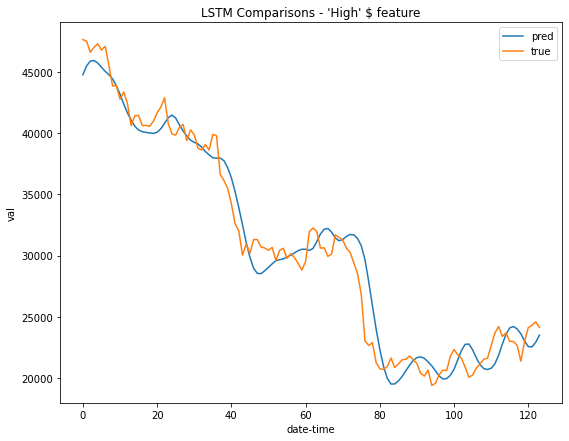

In [99]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 1].flatten(), label = 'pred')
plt.plot(true_vals[:, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons - 'High' $ feature")
plt.legend(loc = 'best')
plt.show()

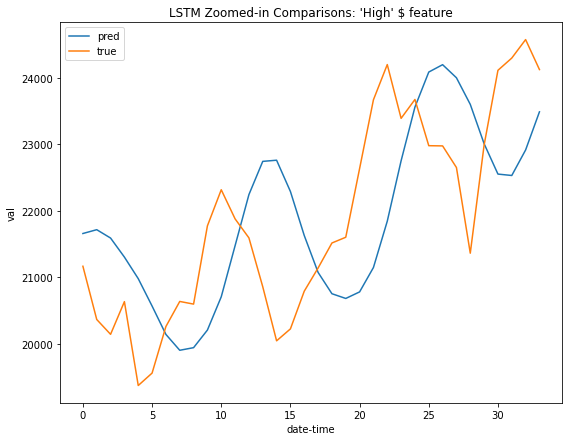

In [100]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 1].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 1].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'High' $ feature")
plt.legend(loc = 'best')
plt.show()

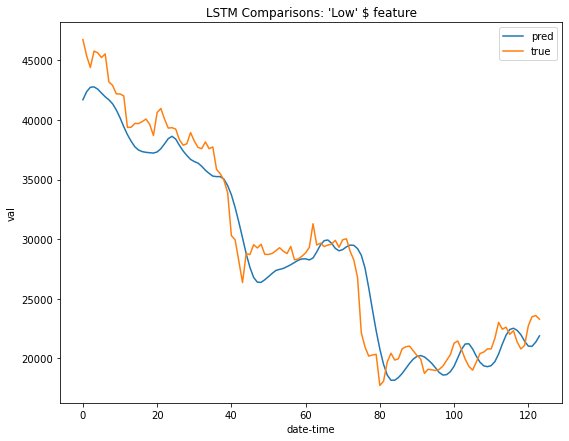

In [101]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 2].flatten(), label = 'pred')
plt.plot(true_vals[:, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Low' $ feature")
plt.legend(loc = 'best')
plt.show()

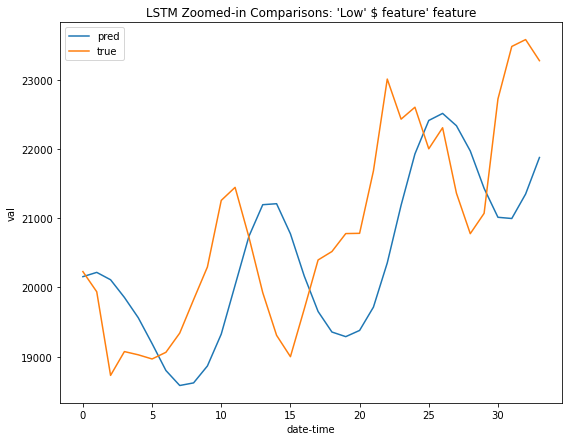

In [102]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:124, 2].flatten(), label = 'pred')
plt.plot(true_vals[90:124, 2].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Low' $ feature' feature")
plt.legend(loc = 'best')
plt.show()

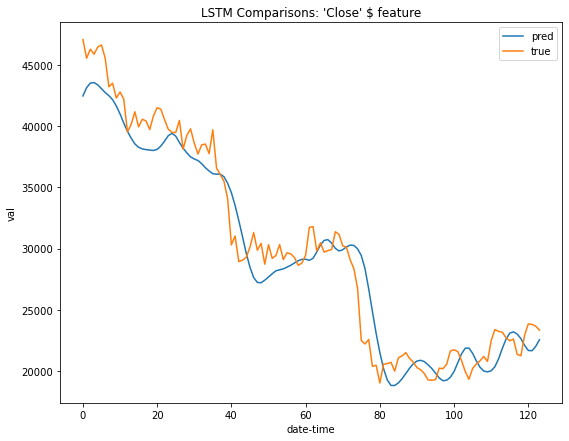

In [103]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 3].flatten(), label = 'pred')
plt.plot(true_vals[:, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Close' $ feature")
plt.legend(loc = 'best')
plt.show()

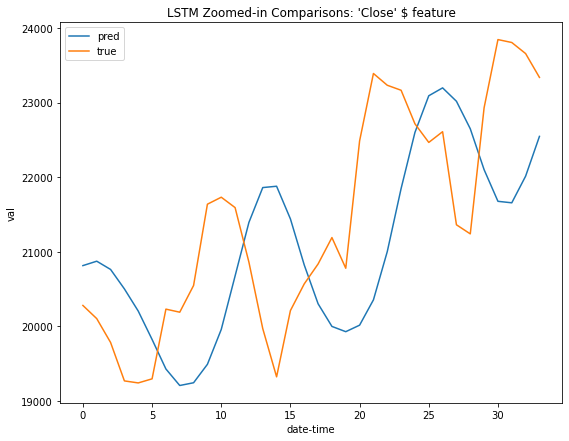

In [104]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:, 3].flatten(), label = 'pred')
plt.plot(true_vals[90:, 3].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Close' $ feature")
plt.legend(loc = 'best')
plt.show()

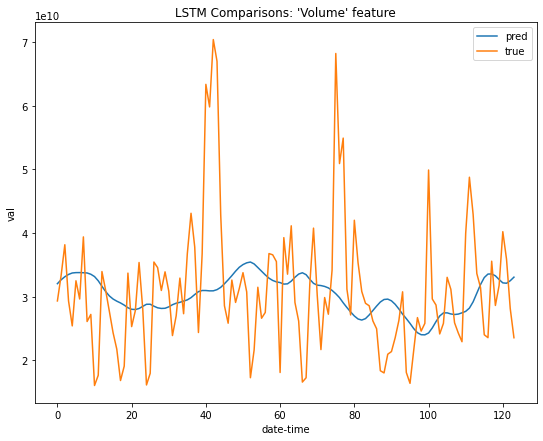

In [105]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[:, 4].flatten(), label = 'pred')
plt.plot(true_vals[:, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Comparisons: 'Volume' feature")
plt.legend(loc = 'best')
plt.show()

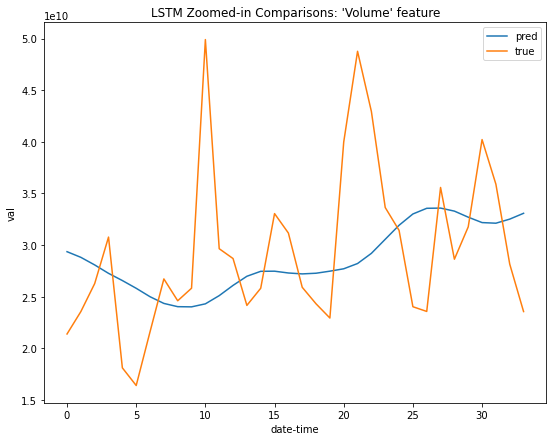

In [106]:
plt.figure(figsize = (9, 7))
plt.plot(pred_vals[90:, 4].flatten(), label = 'pred')
plt.plot(true_vals[90:, 4].flatten(), label = 'true')
plt.xlabel("date-time")
plt.ylabel("val")
plt.title("LSTM Zoomed-in Comparisons: 'Volume' feature")
plt.legend(loc = 'best')
plt.show()

#### Closing remarks:

- All of the features except _Volume_ seem to be predicted well (for now).

- There appears to be a lag between the true and predicted values. The true value happens (slightly) before/ahead of the predicted values.